## Advanced usage
### Using config files

Instead of specifying all inputs using [set_input](https://inbo.github.io/niche_vlaanderen/lowlevel.html#niche_vlaanderen.Niche.set_input), it is possible to use a config file. A config file can be loaded using [read_config_file](https://inbo.github.io/niche_vlaanderen/lowlevel.html#niche_vlaanderen.Niche.read_config_file) or it can be read and executed immediately by using [run_config_file](https://inbo.github.io/niche_vlaanderen/lowlevel.html#niche_vlaanderen.Niche.run_config_file).

The syntax of the config file is explained more in detail in [Niche Configuration file](https://inbo.github.io/niche_vlaanderen/cli.html), but is already introduced here because it will be used in the next examples.

If you want to recreate the examples below, the config files can be found under the `docs` folder, so if you [extract all the data](https://inbo.github.io/niche_vlaanderen/getting_started.html#Interactive-usage) the you should be able to run the examples from the notebook. 



### Comparing Niche classes

Niche models can be compared using a [NicheDelta](lowlevel.rst#niche_vlaanderen.NicheDelta) class. This can be used to compare different scenario's. 

In our example, we will compare the results of the running Niche two times, once using a simple model and once using a full model. 

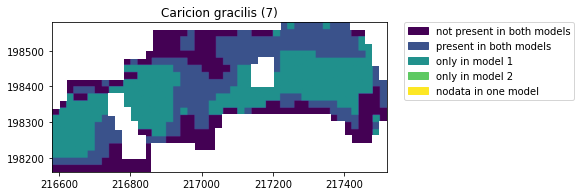

In [1]:
import niche_vlaanderen as nv
import matplotlib.pyplot as plt

simple = nv.Niche()
simple.run_config_file("simple.yml")

full = nv.Niche()
full.run_config_file("full.yml")

delta = nv.NicheDelta(simple, full)
ax = delta.plot(7)
plt.show()

It is also possible to show the areas in a dataframe by using the [table](lowlevel.rst#niche_vlaanderen.NicheDelta.table) attribute.

In [2]:
delta.table.head()

,vegetation,presence,area_ha
0,1,not present in both models,14.44
1,1,present in both models,8.88
2,1,only in model 1,1.00
3,2,not present in both models,11.52
4,2,only in model 1,10.00


Like Niche, NicheDelta also has a write method, which takes a directory as an argument.

In [3]:
delta.write("comparison_output", overwrite_files=True)

### Creating deviation maps

In many cases, it is not only important to find out which vegetation types are possible given the different input files, but also to find out how much change would be required to `mhw` or `mlw` to allow a certain vegetation type.

To create deviation maps, it is necessary to [run](lowlevel.rst#niche_vlaanderen.Niche.run) a model with the `deviation` option.

In [4]:
dev = nv.Niche()
dev.set_input("mhw","../testcase/zwarte_beek/input/mhw.asc")
dev.set_input("mlw","../testcase/zwarte_beek/input/mhw.asc")
dev.set_input("soil_code","../testcase/zwarte_beek/input/soil_code.asc")
dev.run(deviation=True, full_model=False)

The deviation maps can be plotted by specifying either mhw or mlw with the vegetation type, eg mhw_14 (to show the deviation between mhw and the required mhw for vegetation type 14).
Positive values indicate that the actual condition is too dry for the vegetation type. Negative values indicate that the actual condition is too wet for the vegetation type. 

/home/travis/virtualenv/python3.7.1/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


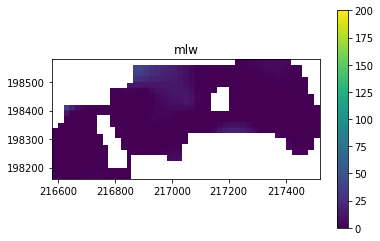

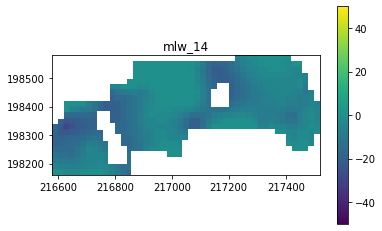

In [5]:
dev.plot("mlw")
dev.plot("mlw_14")

plt.show()

### Creating statistics per shape object

Niche also contains a helper function that allows one to calculate the possible vegetation by using a vector dataset, such as a .geojson or .shp file.

The vegetation is returned as a pandas dataframe, where shapes are identified by their id and the area not covered by a shape gets `shape_id` -1.

In [6]:
df = full.zonal_stats("../testcase/zwarte_beek/input/study_area_l72.geojson")
df

,vegetation,shape_id,presence,area_ha
0,1,0,not present,15.44
1,1,0,present,8.88
2,1,0,no data,0.00
3,2,0,not present,21.52
4,2,0,present,2.80
...,...,...,...,...
79,27,-1,not present,0.00
80,27,-1,present,0.00
81,28,-1,no data,15.16
82,28,-1,not present,0.00


### Using abiotic grids

In certain cases the intermediary grids of Acidity or NutrientLevel need changes, to compensate for specific circumstances.

In that case it is possible to run a Niche model and make some adjustments to the grid and then using an abiotic grid as an input.



In [7]:
import niche_vlaanderen as nv
import matplotlib.pyplot as plt

full = nv.Niche()
full.run_config_file("full.yml")
full.write("output_abiotic", overwrite_files=True)

/home/travis/virtualenv/python3.7.1/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now it is possible to adapt the `acidity` and `nutrient_level` grids outside niche. For this demo, we will use some Python magic to make all nutrient levels one level lower. Note that there is no need to do this in Python, any other tool could be used as well. So if you don't understand this code - don't panic (and ignore the warning)!

In [8]:
import rasterio
with rasterio.open("output_abiotic/full_nutrient_level.tif") as src:
    nutrient_level = src.read(1)
    profile = src.profile
    nodata = src.nodatavals[0]
    
nutrient_level[nutrient_level != nodata] = nutrient_level[nutrient_level != nodata] -1

# we can not have nutrient level 0, so we set all places where this occurs to 1
nutrient_level[nutrient_level ==0 ] = 1

with rasterio.open("output_abiotic/adjusted_nutrient.tif", 'w', **profile) as dst:
    dst.write(nutrient_level, 1)

/home/travis/virtualenv/python3.7.1/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Next we will create a new niche model using the same options as our previous full models, but we will also add the previously calculated acidity and nutrient level values as input, and run with the `abiotic=True` option. Note that we use the `read_config_file` method (and not  `run_config_file`) because we still want to edit the configuration before running.

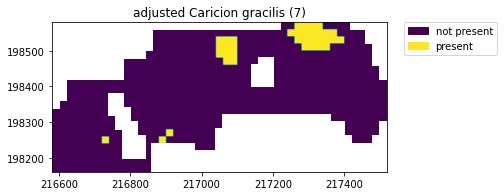

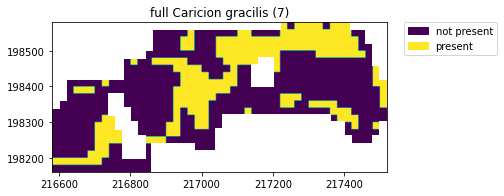

In [9]:
adjusted = nv.Niche()
adjusted.read_config_file("full.yml")
adjusted.set_input("acidity", "output_abiotic/full_acidity.tif")
adjusted.set_input("nutrient_level", "output_abiotic/adjusted_nutrient.tif")
adjusted.name = "adjusted"
adjusted.run(abiotic=True)

adjusted.plot(7)
full.plot(7)
plt.show()

### Overwriting standard code tables

One is free to adapt the [standard code tables](https://inbo.github.io/niche_vlaanderen/codetables.html) that are used by NICHE. By specifying the paths to the adapted code tables in a NICHE class object, the standard code tables can be overwritten. In this way, standard model functioning can be tweaked. However, it is strongly advised to use ecological data that is reviewed by experts and to have in-depth knowledge of the [model functioning](https://inbo.github.io/niche_vlaanderen/model.html).

The possible code tables that can be adapted and set within a [NICHE object](https://inbo.github.io/niche_vlaanderen/lowlevel.html) are:

ct_acidity, ct_soil_mlw_class, ct_soil_codes, lnk_acidity, ct_seepage, ct_vegetation, ct_management, ct_nutrient_level and ct_mineralisation

After adapting the vegetation code table for type 7 (Caricion gracilis) on peaty soil (V) by randomly altering the maximum ``mhw`` and ``mlw`` to 5 and 4 cm resp. (i.e. below ground, instead of standard values of -28 and -29 cm) and saving the file to ct_vegetation_adj7.csv, the adjusted model can be built and run.

In [10]:
adjusted_ct = nv.Niche(ct_vegetation = "ct_vegetation_adj7.csv")
adjusted_ct.read_config_file("full.yml")
adjusted_ct.run()

/home/travis/virtualenv/python3.7.1/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Example of changed potential area of Caricion gracilis vegetation type because of the changes set in the vegetation code table:

/home/travis/virtualenv/python3.7.1/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


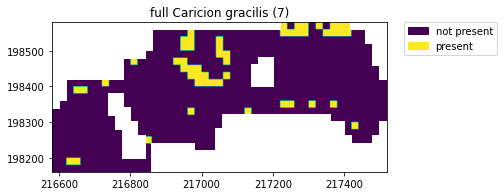

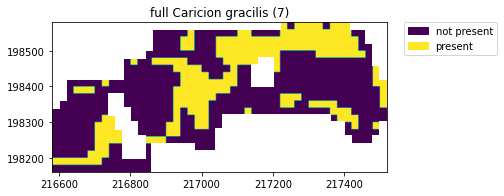

In [11]:
adjusted_ct.plot(7)
full.plot(7)
plt.show()

Potential area is shrinking because of the range of grondwater levels that have become more narrow (excluding the wettest places).